<a href="https://colab.research.google.com/github/oz-e/applied-ml/blob/main/attn_map_CuPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')
    if not os.path.exists('/content/Transformer-MM-Explainability/'):
        # Use custom CLIP to show the attention map
        !git clone https://github.com/hila-chefer/Transformer-MM-Explainability
        !cp -r /content/Transformer-MM-Explainability/CLIP/clip/ /content/applied-ml/
    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install ftfy
    !pip install captum
    !pip install numpy==2.0.2

Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAILdw5QntIUVPHIPzOkhx8xCR3cvEKp11IYc2TwW9lSmo root@e44a06892939

Please use SSH method to clone repo.
Cloning into 'applied-ml'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 156 (delta 4), reused 0 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (156/156), 2.79 MiB | 7.06 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1477 (delta 90), reused 85 (delta 85), pack-reused 1324 (from 1)
Receiving objects: 100% (1477/1477), 25.57 MiB | 19.85 MiB/s, d

In [3]:
import os

if not os.path.exists("CuPL"):
    !git clone https://github.com/sarahpratt/CuPL.git

Cloning into 'CuPL'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 6), reused 52 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 4.68 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)

100%|████████████████████████████████████████| 351M/351M [00:03<00:00, 111MiB/s]


In [7]:
import aml.datasets

all_images = aml.datasets.Flowers102(datasets_path, split='test')

100%|██████████| 345M/345M [00:16<00:00, 21.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 792kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pp0sRXzZFZq15zVOzKjKBu4A9i01nozT
To: /content/applied-ml/datasets/flowers-102/split.json
100%|██████████| 771k/771k [00:00<00:00, 8.16MB/s]


In [8]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts = json.load(f)

In [9]:
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [10]:
# For bridging classsname in dataset with name in CuLP prompts
new_gpt3_prompts = {}

for key, value in gpt3_prompts.items():
    new_key = special_class_mapping.get(key, key)
    new_gpt3_prompts[new_key.lower()] = value

In [11]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [12]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [13]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [14]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [46]:
sample_idx = 500

cls_name = all_images.lab2cname[all_images[sample_idx][1]]
org_img = all_images[sample_idx][0]

clematis


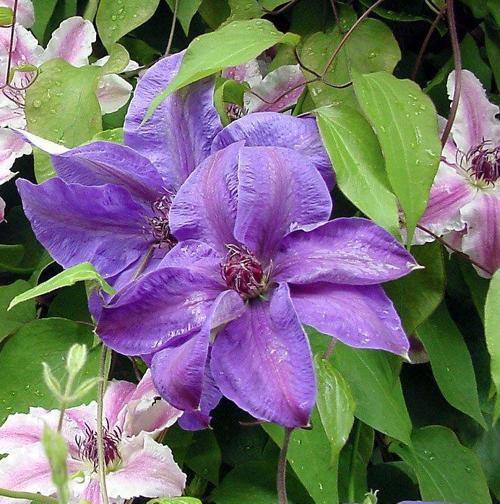

In [47]:
print(cls_name)
org_img

In [48]:
new_gpt3_prompts[cls_name]

['The easiest way to identify a clematis is by its flowers.',
 'The easiest way to identify a clematis is by its flowers.',
 'Clematis is a flowering plant in the buttercup family.',
 'Clematis flowers are typically large, showy, and long-lasting.',
 'A clematis is a type of flowering vine that has large, showy flowers.',
 'To identify a clematis, look for a climbing vine with large, showy flowers.',
 'A clematis is a climbing plant with long, thin stems and large, bright flowers.',
 'The clematis is a type of flower that has a long stem with a small cluster of brightly colored flowers at the top.',
 'Some clematis have showy flowers, while others are more subdued.',
 'Clematis flowers have four petals that are typically white or purple.',
 'A clematis flower has five or six petals that are white or pale purple.',
 'The clematis flower is a climbing plant that has long, thin stems.',
 'A clematis flower has four petals that are typically blue, purple, or white.',
 'The clematis flower 

tensor([8.1482e-03, 7.9880e-03, 2.6131e-04, 1.1320e-03, 5.7335e-03, 1.5068e-03,
        5.4626e-03, 6.0400e-01, 2.4231e-01, 0.0000e+00, 7.1068e-03, 2.4452e-03,
        1.1224e-01, 1.9503e-03], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,the easiest way to identify a cle mat is is by its flowers .


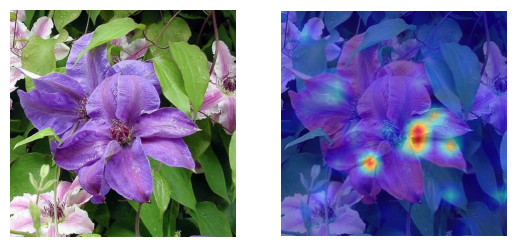

tensor([8.1482e-03, 7.9880e-03, 2.6131e-04, 1.1320e-03, 5.7335e-03, 1.5068e-03,
        5.4626e-03, 6.0400e-01, 2.4231e-01, 0.0000e+00, 7.1068e-03, 2.4452e-03,
        1.1224e-01, 1.9503e-03], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,the easiest way to identify a cle mat is is by its flowers .


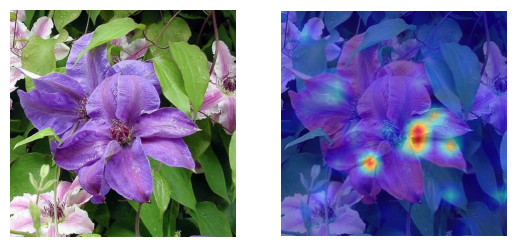

tensor([6.9809e-03, 5.1465e-01, 1.5051e-01, 1.1444e-02, 5.7945e-03, 3.1464e-02,
        6.5193e-03, 1.3609e-03, 5.6305e-03, 6.5207e-05, 7.3280e-03, 8.7509e-03,
        2.4902e-01], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,cle mat is is a flowering plant in the butter cup family .


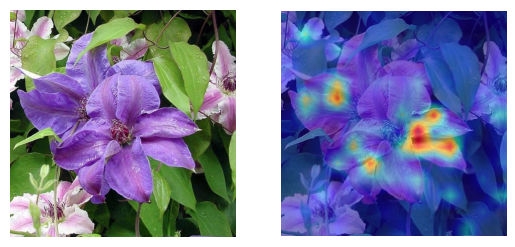

In [49]:
img = preprocess(org_img).unsqueeze(0).to(device)
texts = new_gpt3_prompts[cls_name][:3]  # choose the first few prompts as examples
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=org_img)
  plt.show()